# Exploratory spatial analysis of rat brain dataset

#### Demo notebook - February 2024 - LEM Tideman - TU Delft

In [1]:
import pickle
import scipy.io
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, TwoSlopeNorm, LinearSegmentedColormap
from matplotlib.patches import ConnectionPatch
import matplotlib.ticker as mticker
import string
import copy

In [2]:
# Import necessary Moran Imaging modules
from moran_imaging.spatial_weights_matrix import define_spatial_weights_matrix
from moran_imaging.local_global_spatial_autocorrelation import MoranGlobal, MoranLocal
from moran_imaging.plotting import plot_moran_local_scatterplot, position_discrete_colorbar_ticks

In [3]:
# Import necessary code
#%run Centralized_conditional_randomization_engine.py
#%run Local_global_spatial_autocorrelation.py
#%run Spatial_weights_matrix.py
#%run Plotting.py 

In [4]:
def make_ion_image(data, image_shape, background_mask, fill_zeros=True, show_image=True, colormap='coolwarm'):
    """Plot ion image from one column of the providede IMS dataset."""
    
    # Fill background pixels with zeros (default) or NaN
    pixel_grid = np.zeros((image_shape[0]*image_shape[1], ))
    pixel_grid[np.invert(background_mask)] = data
    
    if not fill_zeros:
        pixel_grid[background_mask] = np.nan
    
    # Reshape data
    ion_image = np.reshape(pixel_grid, image_shape)
    
    # Plot ion image 
    if show_image == True: 
        plt.figure(dpi=100)
        plt.imshow(ion_image, cmap=colormap)
        plt.axis('off')
        plt.show()
        
    return ion_image

In [5]:
def compute_global_spatial_autocorrelation_one_mz_bin(measure, index, dataset, image_shape, background_mask, W, num_permute=999, random_seed=0):
    """
    Facilitate parallel computation of global Moran's I statistics for a range of ion images.
    
    Inputs
    ----------
    measure         : string
                      Measure of global spatial autocorrelation, either "Moran" or "Geary"
    index           : integer
                      Column index corresponding to the m/z bin of interest
    dataset         : array
                      Imaging mass spectrometry dataset
    acquisition_mask: array
                      Boolean array of the same dimensions as dataset
    W               : spatial weights matrix object
    num_permute     : integer
                      Number of random permutations for calculating the pseudo p-values
    
    Output
    -------
    Moran_Global    : global Moran's I object 
    OR
    Geary_Global    : global Geary's c object
    """
    
    # Set random seed 
    np.random.seed(random_seed)
    
    # Reshape dataset column into an ion image and fill background with zero
    ion_image = make_ion_image(dataset[:, index], image_shape, background_mask, fill_zeros=True, show_image=False)
    
    # Compute global measure of spatial autocorrelation
    if measure == "Moran":
        return MoranGlobal(ion_image, W, background_mask, num_permute)
        # return Moran_Global_bis(ion_image_final, W, num_permute)
    if measure == "Geary": 
        return GearyGlobal(ion_image, W, num_permute)

In [6]:
# Set seaborn plotting style
sns.set_style("darkgrid")

# Set rounding precision of m/z values
rounding_precision = 3

# Ignore warnings
warnings.filterwarnings("ignore")

# Define colormaps
colormap_moran = sns.blend_palette(["darkblue", "1", "crimson"], as_cmap=True)
colormap_reverse = sns.blend_palette(["1", "darkblue"], as_cmap=True)

### Upload imaging mass spectrometry dataset

In [7]:
with open('Data/Demo_rat_brain_data.pickle', 'rb') as file:
    data_metadata_dictionary = pickle.load(file)
    
dataset = data_metadata_dictionary['IMS_dataset']
mz_bin_values = data_metadata_dictionary['index_to_mz']
background_mask = data_metadata_dictionary['background_mask']
image_shape = data_metadata_dictionary['image_shape']
total_num_pixels = dataset.shape[0]
total_num_mz_bins = dataset.shape[1]

### Computation of Moran's I for all m/z bins

In [8]:
# Definition of the spatial weights matrix
weights_matrix = define_spatial_weights_matrix(image_shape, 'Queen', 1, background_mask, with_lower_order=False)
weights_matrix.transform = "r"

In [9]:
# Parallel computation of each feature's global spatial autocorrelation
# Runtime of 3.4 minutes on a workstation with the following specs: 256 GB RAM, 52 cores, Windows 10, 64-bit OS
global_spatial_autocorrelation_per_feature = Parallel(n_jobs=-1, prefer="threads", verbose=1, timeout=None)(delayed(compute_global_spatial_autocorrelation_one_mz_bin)
                                                                                                            ("Moran", index, dataset, image_shape, background_mask, weights_matrix, 999) 
                                                                                                            for index in list(range(total_num_mz_bins)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 52 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 out of 100 | elapsed:  3.9min remaining:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished


In [10]:
Moran_list = []
Pvalues_list = []
Zscores_list = []

for index in range(dataset.shape[1]):
    I = global_spatial_autocorrelation_per_feature[index].Moran_I_global
    p_sim = global_spatial_autocorrelation_per_feature[index].p_sim
    z_sim = global_spatial_autocorrelation_per_feature[index].z_sim
    Moran_list.append(np.round(I, 5))
    Pvalues_list.append(np.round(p_sim, 5))
    Zscores_list.append(np.round(z_sim, 5))

In [11]:
# Minimium and maximum values of Moran's I 
mz_spatial_autocorrelation_min = Moran_list.index(min(Moran_list))
print("Min:", min(Moran_list), "m/z:", mz_spatial_autocorrelation_min)
mz_spatial_autocorrelation_max = Moran_list.index(max(Moran_list))
print("Max:", max(Moran_list), "m/z:", mz_spatial_autocorrelation_max)

Min: -0.0033 m/z: 98
Max: 0.85403 m/z: 5


In [12]:
# Measure statistical significance of Moran's I statistics
significance_threshold = 0.002
significant_spatial_autocorrelation = [Pvalues_list[i] for i in range(dataset.shape[1]) if Pvalues_list[i] <= significance_threshold]
print(len(significant_spatial_autocorrelation), "ion images, out of a total of", dataset.shape[1], "ion images, have significant spatial autocorrelation")

98 ion images, out of a total of 100 ion images, have significant spatial autocorrelation


In [13]:
# Mean ion intensity per m/z bin
mean_intensity = np.mean(dataset, axis=0)

### Significance testing of Moran's I 

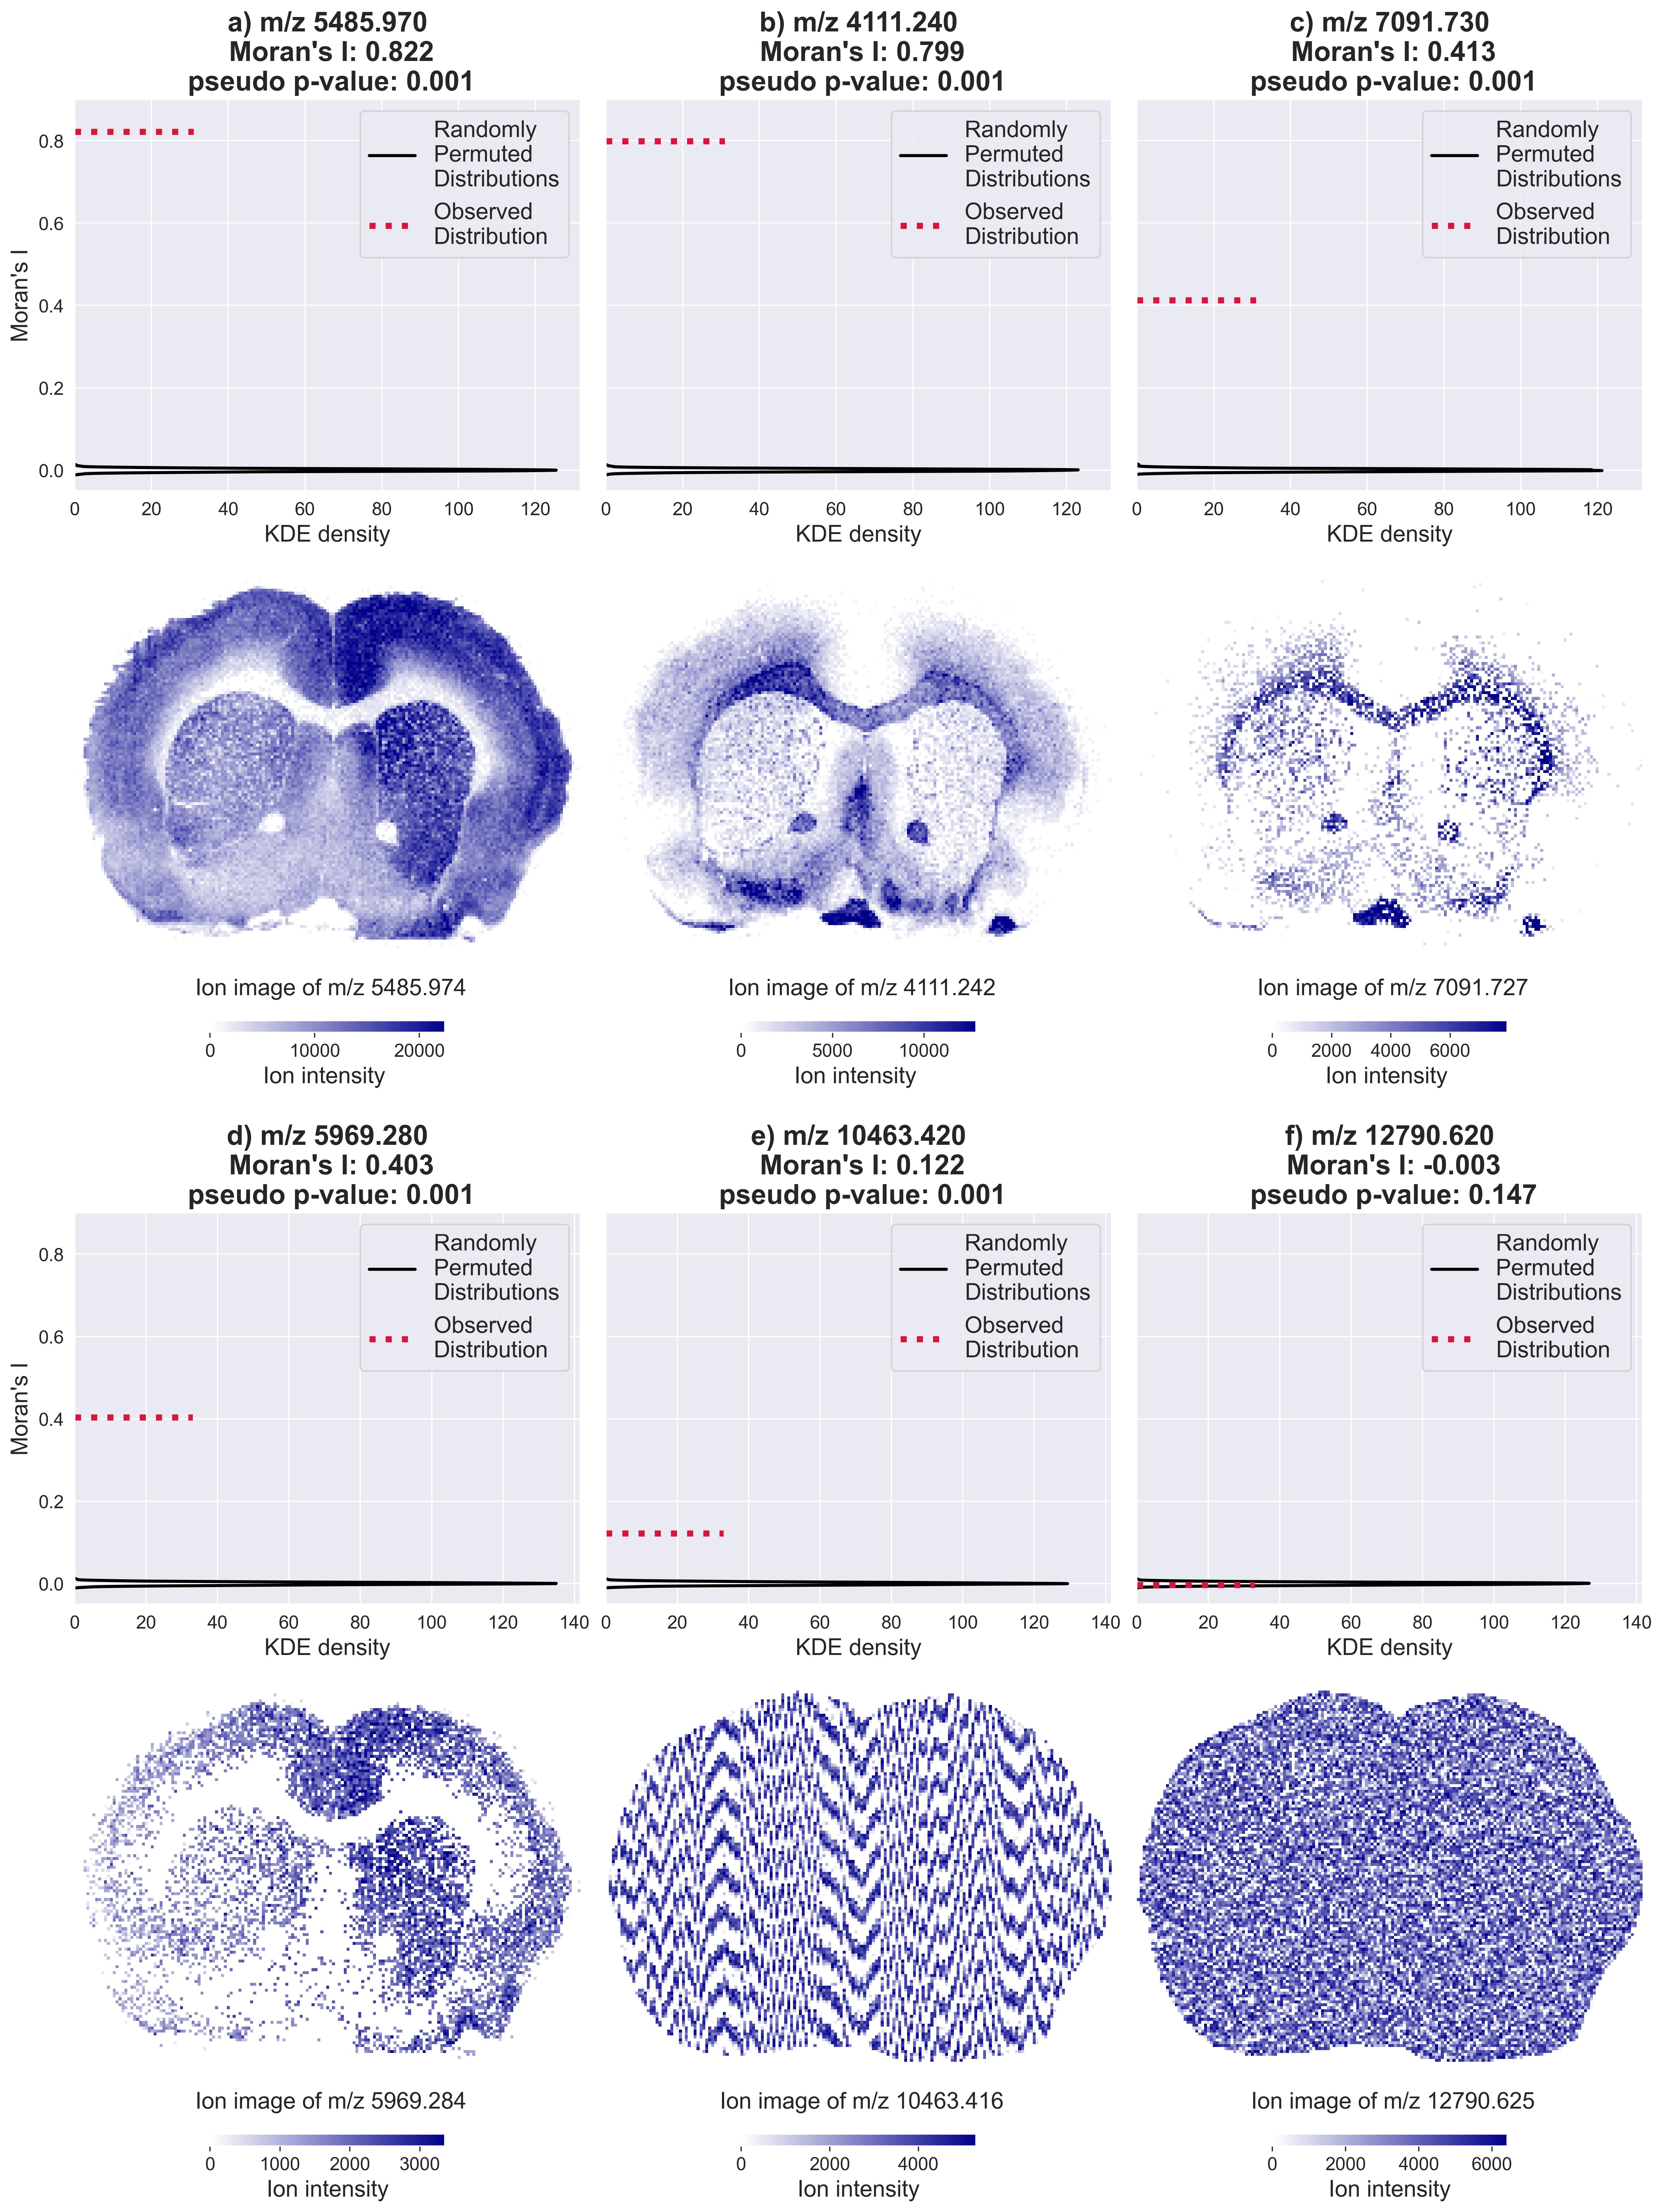

In [14]:
alphabet = list(string.ascii_lowercase)
demo_list = [43, 23, 63, 57, 97, 98]
fig, axes = plt.subplots(nrows=4, ncols=3, sharex='row', sharey='row', figsize=(15, 20), dpi=350, constrained_layout=True)
plt.subplots_adjust(hspace=0.1, wspace=0.2)

for ax_index, feature_index in enumerate(demo_list[:3]):
    moran_object = global_spatial_autocorrelation_per_feature[feature_index]
    global_moran = moran_object.Moran_I_global
    pseudo_p_value = moran_object.p_sim
    sns.kdeplot(y=moran_object.sim, color="k", fill=False, ax=axes[0, ax_index], label="Randomly \n"+ "Permuted \n" + "Distributions", linewidth=2)
    axes[0, ax_index].hlines(global_moran, 0, int(axes[0, ax_index].get_xbound()[1]/4.2), color="crimson", linestyles="dotted", label="Observed \n" + "Distribution", linewidth=4)
    axes[0, ax_index].set_title(alphabet[ax_index] + ") m/z " + "{:.3f}".format(round(mz_bin_values[feature_index], 2)) + "\n Moran's I: " + str(round(global_moran, rounding_precision)) + "\n" +
                                " pseudo p-value: " + str(pseudo_p_value), fontweight="bold", fontsize=18)  
    axes[0, ax_index].set_ylim([-0.05, 0.9])
    axes[0, ax_index].set_ylabel("Moran's I", fontsize=15)
    axes[0, ax_index].set_xlabel("KDE density", fontsize=15)
    axes[0, ax_index].tick_params(axis="x", labelsize=12)
    axes[0, ax_index].tick_params(axis="y", labelsize=12)
    axes[0, ax_index].legend(loc="upper right", fontsize=15)
    
for ax_index, feature_index in enumerate(demo_list[:3]):
    ion_image = make_ion_image(dataset[:, feature_index], image_shape, background_mask, fill_zeros=False, show_image=False)
    mini_fig = axes[1, ax_index].imshow(ion_image, vmin=np.nanpercentile(ion_image, 1), vmax=np.nanpercentile(ion_image, 99), cmap=colormap_reverse)
    axes[1, ax_index].set_title("\n Ion image of m/z " + "{:.3f}".format(round(mz_bin_values[feature_index], rounding_precision)), y=-0.15, fontsize=15)
    axes[1, ax_index].axis("off")
    cbar = fig.colorbar(mini_fig, ax=axes[1, ax_index], orientation="horizontal", fraction=0.03)
    cbar.set_label("Ion intensity \n", size=15)
    cbar.ax.tick_params(labelsize=12)

for ax_index, feature_index in enumerate(demo_list[3:]):
    moran_object = global_spatial_autocorrelation_per_feature[feature_index]
    global_moran = moran_object.Moran_I_global
    pseudo_p_value = moran_object.p_sim
    sns.kdeplot(y=moran_object.sim, color="k", fill=False, ax=axes[2, ax_index], label="Randomly \n"+ "Permuted \n" + "Distributions", linewidth=2)
    axes[2, ax_index].hlines(global_moran, 0, int(axes[2, ax_index].get_xbound()[1]/4.2), color="crimson", linestyles="dotted", label="Observed \n" + "Distribution", linewidth=4)
    axes[2, ax_index].set_title(alphabet[ax_index+3] + ") m/z " + "{:.3f}".format(round(mz_bin_values[feature_index], 2)) + "\n Moran's I: " + str(round(global_moran, rounding_precision)) + "\n" +
                                " pseudo p-value: " + str(pseudo_p_value), fontweight="bold", fontsize=18)  
    axes[2, ax_index].set_ylim([-0.05, 0.9])
    axes[2, ax_index].set_ylabel("Moran's I", fontsize=15)
    axes[2, ax_index].set_xlabel("KDE density", fontsize=15)
    axes[2, ax_index].tick_params(axis="x", labelsize=12)
    axes[2, ax_index].tick_params(axis="y", labelsize=12)
    axes[2, ax_index].legend(loc="upper right", fontsize=15)
    
for ax_index, feature_index in enumerate(demo_list[3:]):
    ion_image = make_ion_image(dataset[:, feature_index], image_shape, background_mask, fill_zeros=False, show_image=False)
    mini_fig = axes[3, ax_index].imshow(ion_image, vmin=np.nanpercentile(ion_image, 1), vmax=np.nanpercentile(ion_image, 99), cmap=colormap_reverse)
    axes[3, ax_index].set_title("\n Ion image of m/z " + "{:.3f}".format(round(mz_bin_values[feature_index], rounding_precision)), y=-0.15, fontsize=15)
    axes[3, ax_index].axis("off")
    cbar = fig.colorbar(mini_fig, ax=axes[3, ax_index], orientation="horizontal", fraction=0.03)
    cbar.set_label("Ion intensity", size=15)
    cbar.ax.tick_params(labelsize=12)

#fig.savefig("./Nature_Figures/Final_Figure_1.png", format="png", bbox_inches="tight")
plt.show()

### Moran scatterplots and quadrant maps

In [15]:
def plot_Moran_scatterplot_quadrantplot(feature_index, dataset, weights_matrix, mz_bin_values, image_shape, background_mask, 
                                            mean_intensity, colormap_moran, save_name, index_plot_start=0, rounding_precision=3):
    # Figure numbering
    alphabet = list(string.ascii_lowercase)[index_plot_start:]
    
    # Ion image
    ion_image_with_background = make_ion_image(dataset[:, feature_index], image_shape, background_mask, fill_zeros=True, show_image=False)
    ion_image_display = make_ion_image(dataset[:, feature_index], image_shape, background_mask, fill_zeros=False, show_image=False)

    # Spatial autocorrelation map
    local_moran_object = MoranLocal(ion_image_with_background, weights_matrix, background_mask, 999, 52)
    local_moran_statistics = local_moran_object.Moran_I_local
    local_moran_statistics[background_mask==True] = None
    local_Moran_map = np.reshape(local_moran_statistics, image_shape)

    # Spatial map of pixel quadrant membership
    moran_quadrants = local_moran_object.quadrant
    moran_quadrants = moran_quadrants.astype(float)
    moran_quadrants[background_mask==True] = None
    quadrants_image = np.reshape(moran_quadrants, image_shape)

    fig = plt.figure(figsize=(15, 12), dpi=350, constrained_layout=True)
    gridspec = plt.GridSpec(3, 2, height_ratios=[1, 1, 0.05])
    
    # Ion image
    axes_top_right = fig.add_subplot(gridspec[0,0])
    ion_image = axes_top_right.imshow(ion_image_display, vmin=np.nanpercentile(ion_image_display, 1), vmax=np.nanpercentile(ion_image_display, 99), 
                                      cmap=colormap_reverse, interpolation=None)
    axes_top_right.set_title(alphabet[0] + ") Ion image of m/z " + "{:.3f}".format(round(mz_bin_values[feature_index], rounding_precision)), 
                             y=1.05, fontsize=15, fontweight="bold")
    divider = make_axes_locatable(axes_top_right)
    cax = divider.append_axes("left", size="5%", pad="2%")
    cbar = plt.colorbar(ion_image, cax=cax, orientation="vertical")
    cbar.ax.yaxis.set_ticks_position("left")
    cbar.ax.yaxis.set_label_position("left")
    cbar.set_label("Ion intensity", size=12)
    cbar.ax.tick_params(labelsize=10)
    axes_top_right.axis("off")

    # Spatial autocorrelation map
    axes_top_right = fig.add_subplot(gridspec[0,1])
    moran_image = axes_top_right.imshow(local_Moran_map, norm=TwoSlopeNorm(vmin=np.nanpercentile(local_Moran_map, 0.5), vcenter=0, vmax=np.nanpercentile(local_Moran_map, 99.5)), 
                                        cmap=colormap_moran, interpolation=None)
    axes_top_right.set_title(alphabet[1] + ") Spatial autocorrelation map of m/z " + "{:.3f}".format(round(mz_bin_values[feature_index], rounding_precision)), 
                             y=1.05, fontsize=15, fontweight="bold")
    divider = make_axes_locatable(axes_top_right)
    cax = divider.append_axes("right", size="5%", pad="2%")
    cbar = plt.colorbar(moran_image, cax=cax, orientation="vertical")
    cbar.ax.set_yscale('linear')
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.set_ticks_position("right")
    cbar.ax.yaxis.set_label_position("right")
    cbar.set_label("Moran statistics", size=12, labelpad=15, rotation=270)
    cbar.ax.tick_params(labelsize=10)
    cbar.update_ticks()

    # Ensure scientific notation
    cbar.formatter = mticker.ScalarFormatter(useMathText=True) 
    cbar.formatter.set_powerlimits((-0.001, 0.001))  
    cbar.update_ticks()  # Apply formatter
    axes_top_right.axis("off")

    # Moran scatterplot
    axes_middle = fig.add_subplot(gridspec[1,0])
    colormap_scatterplot = ListedColormap(['#ff85a5', 'black', 'lightskyblue', 'white']) 
    slope, intercept, R2, ion_intensity_mean, spatial_lag_mean = plot_moran_local_scatterplot(local_moran_object, weights_matrix, background_mask, 
                                                                                              ion_image_with_background, round(mean_intensity[feature_index], rounding_precision), 
                                                                                              None, colormap_scatterplot, axes_middle, with_colorbar=False)
    axes_middle.set_title(alphabet[2] + ") Moran scatterplot of m/z " + "{:.3f}".format(round(mz_bin_values[feature_index], rounding_precision)) + "\n Moran's I = " + "{:.3f}".format(Moran_list[feature_index]) + " & R2 = " + str(np.round(R2, 4)), 
                          y=1.0, fontsize=15, fontweight="bold")
    tick_labels = ['High-high (HH) quadrant \n'+'High intensity & High spatial lag \n'+'Spatial clustering', 'Low-high (LH) quadrant \n'+'Low intensity & High spatial lag \n'+'Spatial outliers', 
                   'Low-low (LL) quadrant \n'+ 'Low intensity & Low spatial lag \n'+'Spatial clustering', 'High-low (HL) quadrant \n'+'High intensity & Low spatial lag \n'+'Spatial outliers'] 
    tick_loc = position_discrete_colorbar_ticks(1, 4)
    axes_middle.set_xlabel('Ion intensity \n', fontsize=12)
    axes_middle.set_ylabel('Spatial lag', fontsize=12)

    # Moran quandrant map
    axes_bottom = fig.add_subplot(gridspec[1,1])
    image_quadrant = axes_bottom.imshow(quadrants_image, cmap=colormap_scatterplot, interpolation=None)
    axes_bottom.set_title(alphabet[3] + ") Moran quadrant map of m/z " + "{:.3f}".format(round(mz_bin_values[feature_index], rounding_precision)), y=1.05, fontsize=15, fontweight="bold")

    divider = make_axes_locatable(axes_bottom) 
    cax = divider.append_axes("right", size="5%", pad="2%") 
    cbar = plt.colorbar(moran_image, cax=cax, orientation="vertical") 
    cbar.ax.set_yscale('linear') 
    cbar.formatter.set_powerlimits((0, 0)) 
    cbar.ax.yaxis.set_ticks_position("right") 
    cbar.ax.yaxis.set_label_position("right") 
    cbar.set_label("Moran statistics", size=12, labelpad=15, rotation=270) 
    cbar.ax.tick_params(labelsize=10) 
    cbar.update_ticks() 
    axes_bottom.axis("off")

    # Define Moran scatterplot colorbar (bottom)
    cax = fig.add_subplot(gridspec[2, :])  # Full-width subplot for the colorbar
    tick_loc = position_discrete_colorbar_ticks(1, 4)
    cbar_total = plt.colorbar(image_quadrant, cax=cax, ticks=tick_loc, orientation='horizontal', drawedges=True)

    # Customize colorbar ticks and labels
    tick_labels = ['High-high quadrant \n'+'High intensity & High spatial lag \n'+'Spatial clustering', 
                   'Low-high quadrant \n'+'Low intensity & High spatial lag \n'+'Spatial outliers', 
                   'Low-low quadrant \n'+ 'Low intensity & Low spatial lag \n'+'Spatial clustering', 
                   'High-low quadrant \n'+'High intensity & Low spatial lag \n'+'Spatial outliers']

    cbar_total.ax.set_xticklabels(tick_labels, fontsize=12)
    cbar_total.outline.set_color('black')
    cbar_total.dividers.set_color('black')
    cbar_total.dividers.set_linewidth(1)
    cbar_total.outline.set_linewidth(1)

    # Align y-axis labels of all plots
    fig.align_labels() 

    # Save Figure
    #fig.savefig(save_name + ".png", format="png", bbox_inches="tight")
    plt.show()

    return moran_quadrants, slope, intercept, R2, ion_intensity_mean, spatial_lag_mean

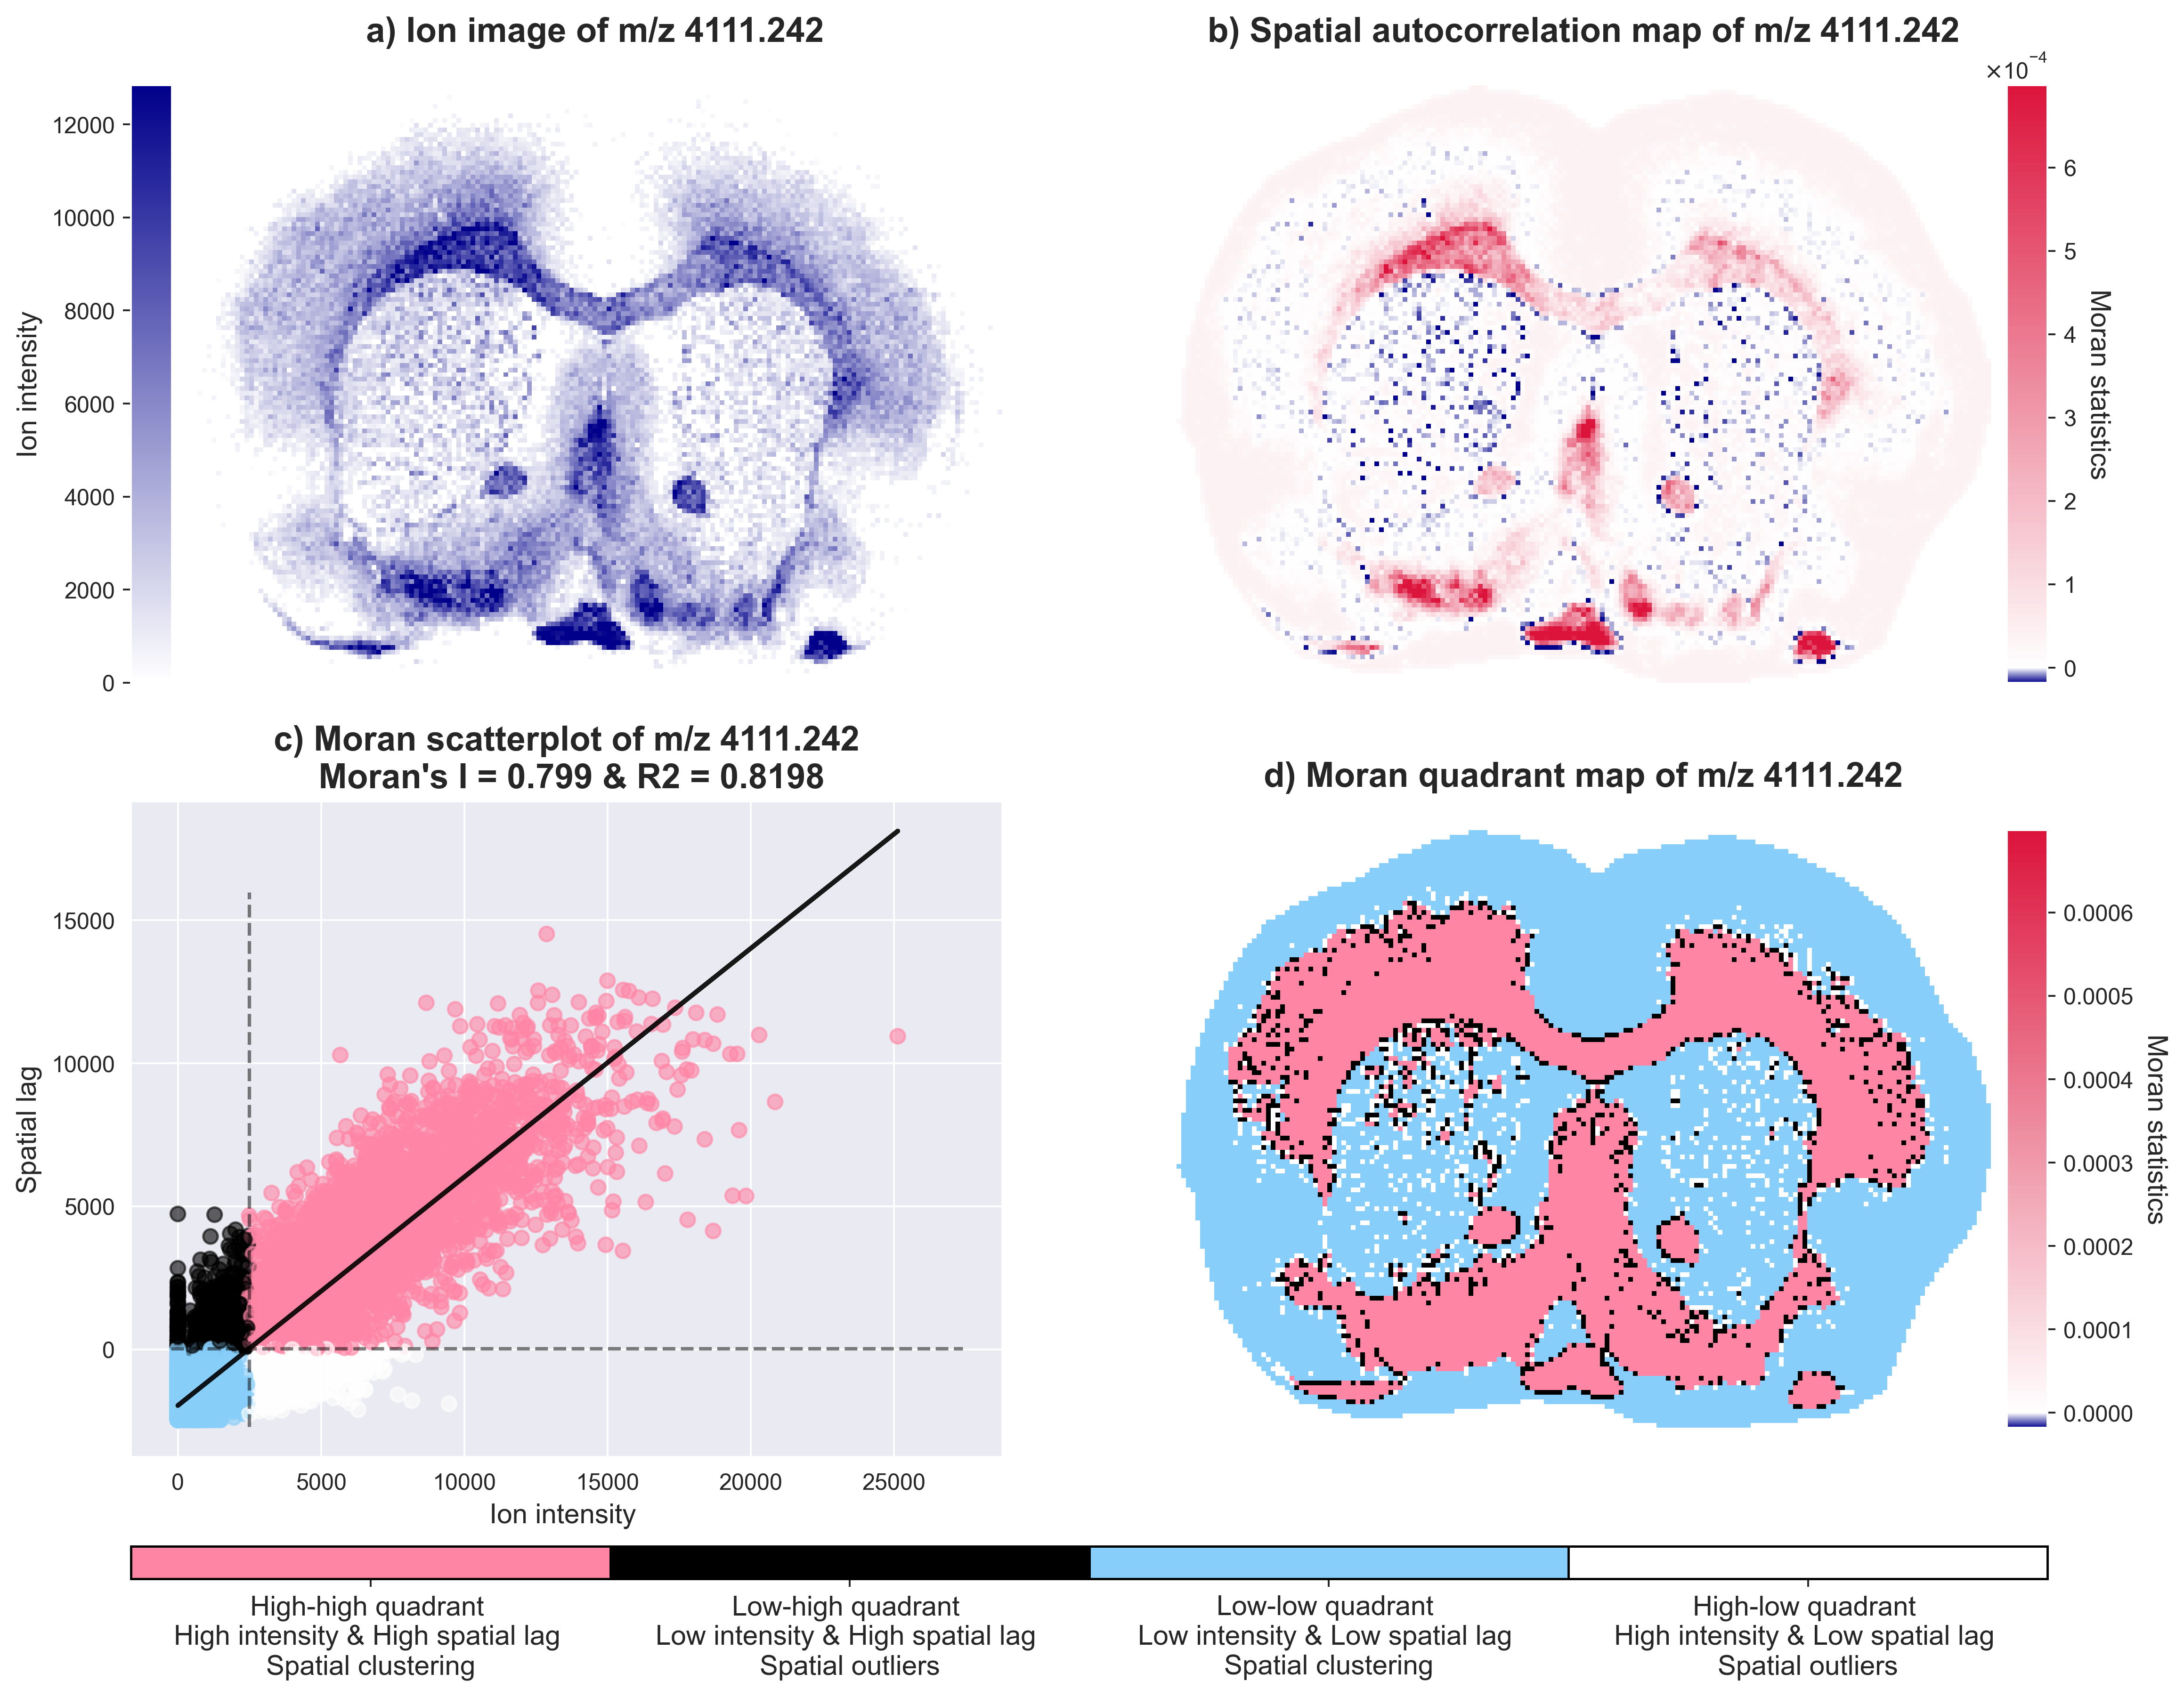

Moran's I: 0.79887
R^2: 0.8198
Mean ion intensity: 2483.7466
Mean spatial lag: 20.1495
Percentage of pixels in spatial clusters:  88.176 %


In [16]:
feature_index = 23
save_name = "./Nature_Figures/Figure_5"
moran_quadrants, slope, intercept, R2, ion_intensity_mean, spatial_lag_mean = plot_Moran_scatterplot_quadrantplot(feature_index, dataset, weights_matrix, mz_bin_values, 
                                                                                                                  image_shape, background_mask, mean_intensity, colormap_moran, 
                                                                                                                  save_name, index_plot_start=0)

print("Moran's I:", Moran_list[feature_index])
print("R^2:", np.round(R2, 4))
print("Mean ion intensity:", np.round(ion_intensity_mean, 4))
print("Mean spatial lag:", np.round(spatial_lag_mean, 4))

# Percentage of pixels in the high-high and low-low quadrants (spatial clustering of high and low values)
card_high_high = np.sum(moran_quadrants == 1)
card_low_high = np.sum(moran_quadrants == 2)
card_low_low = np.sum(moran_quadrants == 3)
card_high_low = np.sum(moran_quadrants == 4)
Pspatial_clustering = 100 * (card_high_high + card_low_low)/(card_high_high + card_low_high + card_low_low + card_high_low)
print('Percentage of pixels in spatial clusters: ', np.round(Pspatial_clustering, 3), '%') 

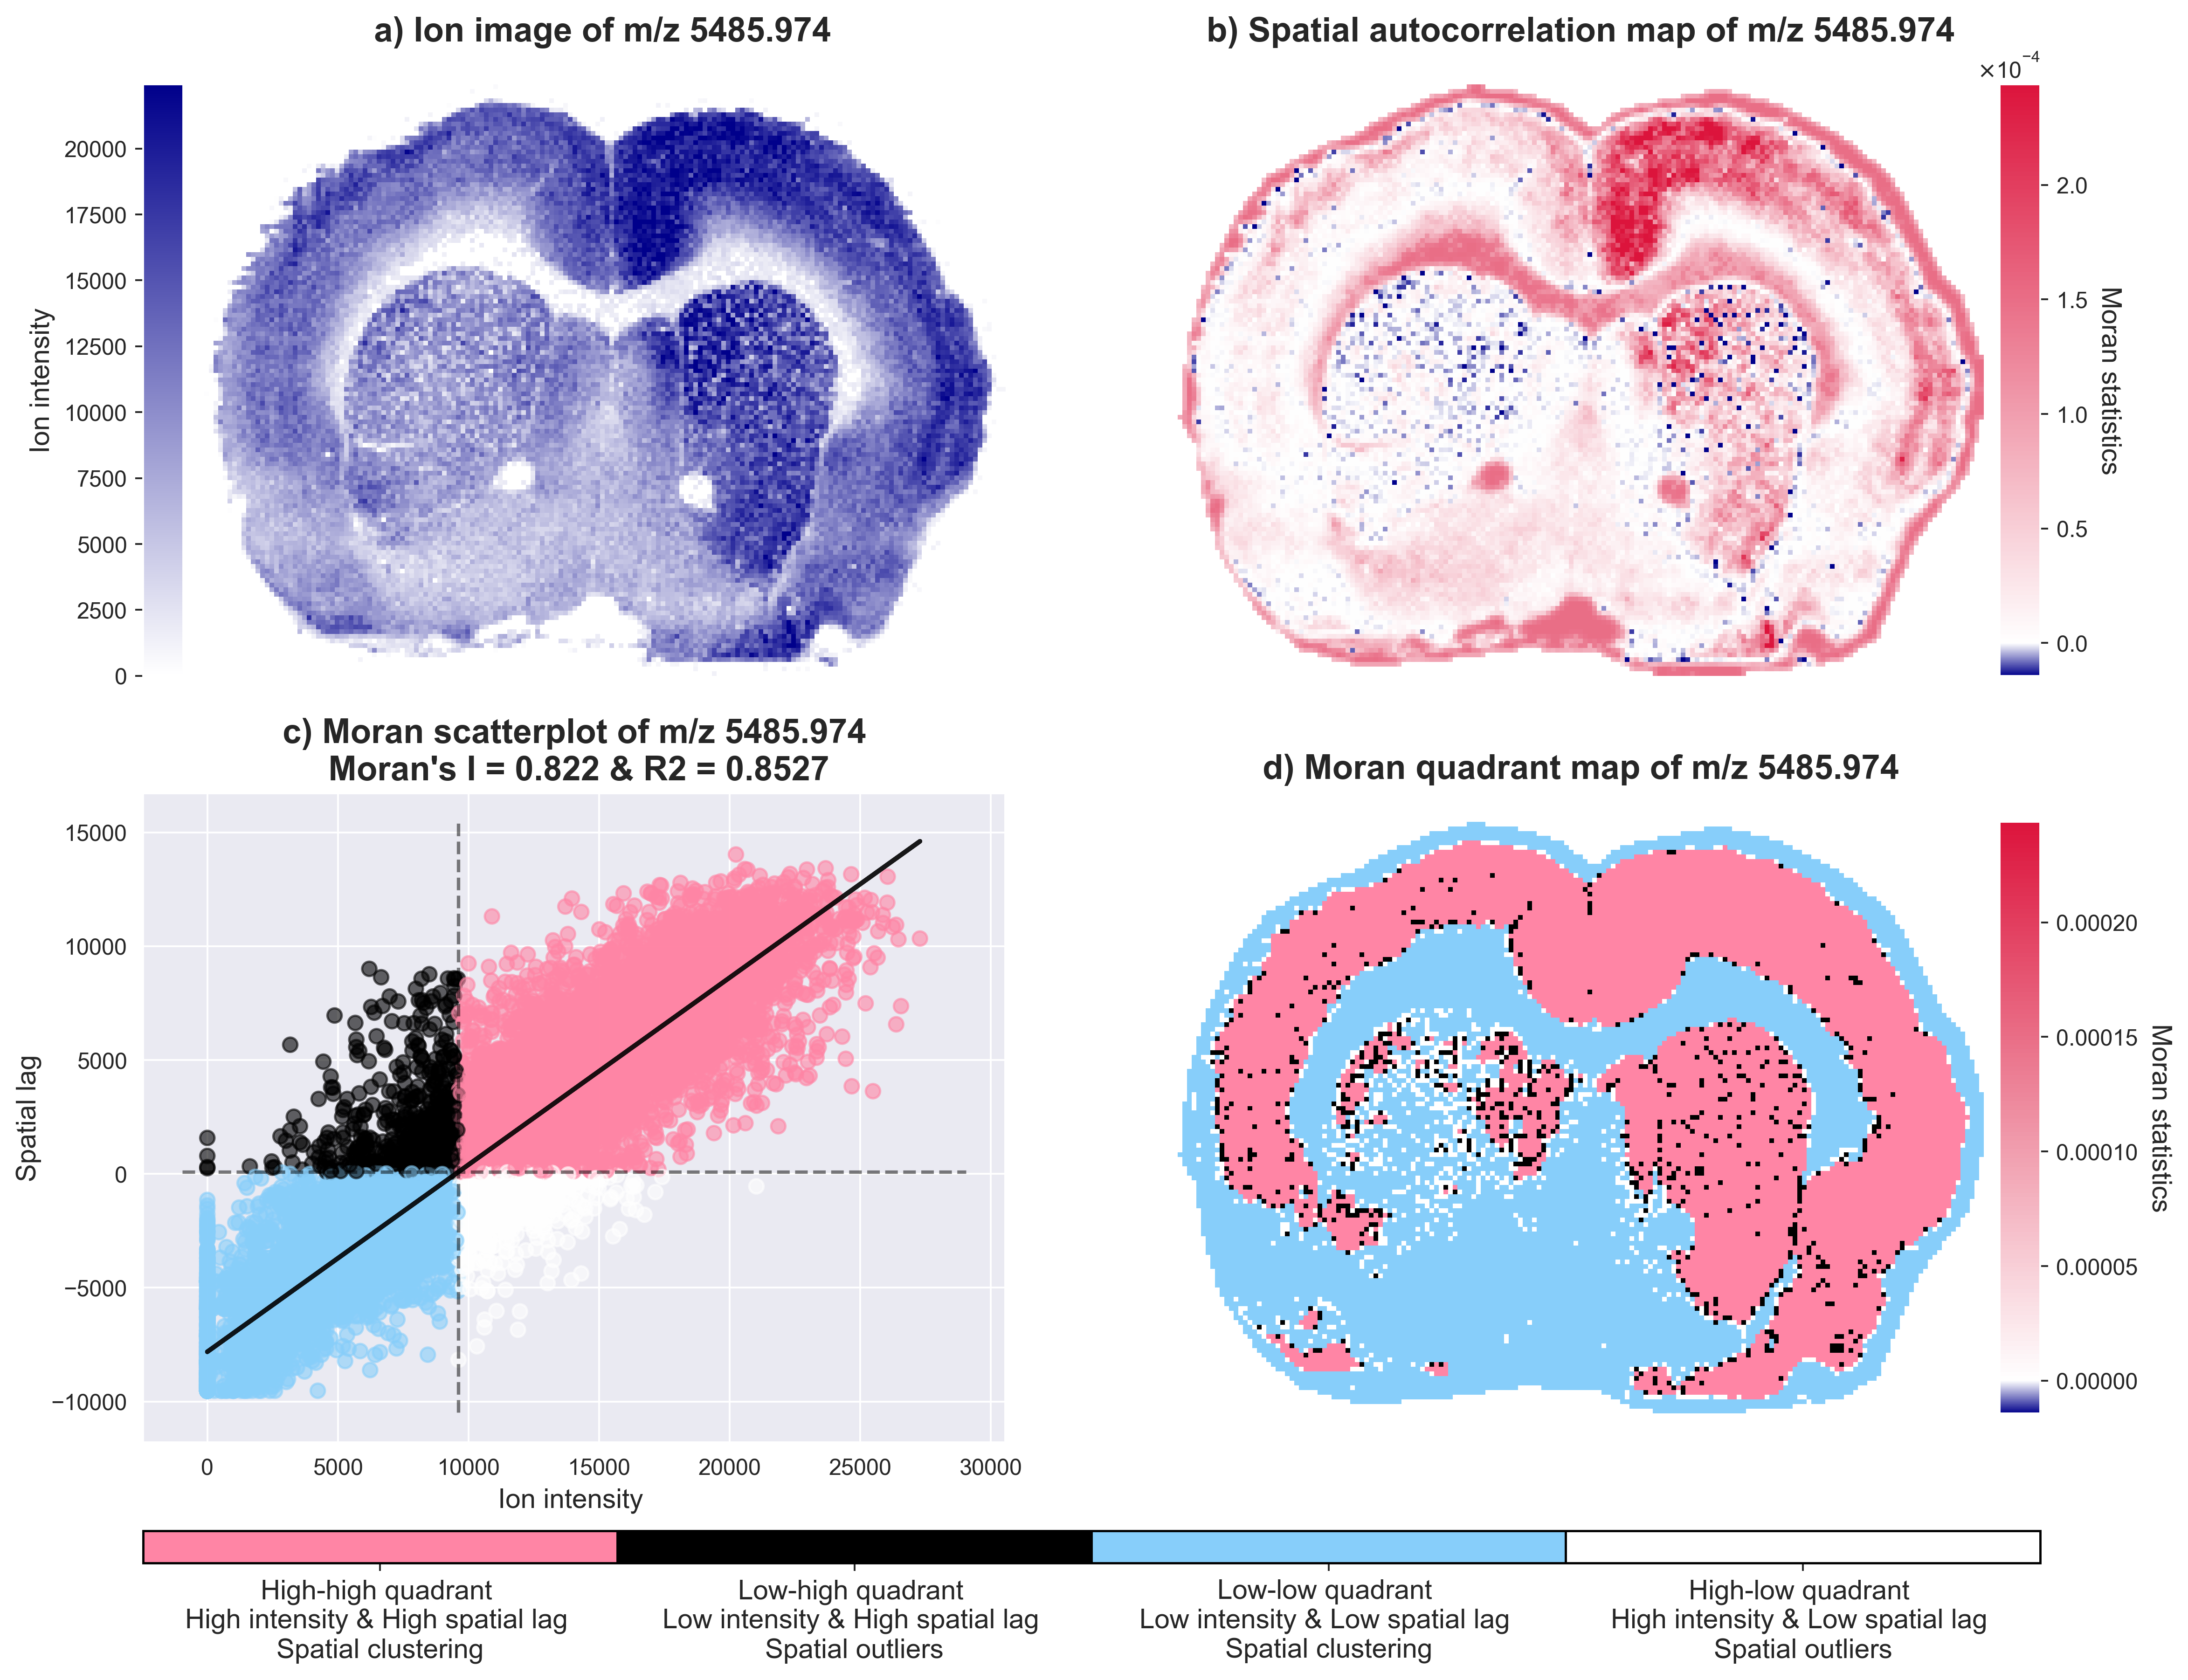

Moran's I: 0.82177
R^2: 0.8527
Mean ion intensity: 9601.8706
Mean spatial lag: 76.9978
Percentage of pixels in spatial clusters:  89.969 %


In [17]:
feature_index = 43
save_name = "./Nature_Figures/Figure_S1"
moran_quadrants, slope, intercept, R2, ion_intensity_mean, spatial_lag_mean = plot_Moran_scatterplot_quadrantplot(feature_index, dataset, weights_matrix, mz_bin_values, 
                                                                                                                  image_shape, background_mask, mean_intensity, colormap_moran, 
                                                                                                                  save_name, index_plot_start=0)

print("Moran's I:", Moran_list[feature_index])
print("R^2:", np.round(R2, 4))
print("Mean ion intensity:", np.round(ion_intensity_mean, 4))
print("Mean spatial lag:", np.round(spatial_lag_mean, 4))

# Percentage of pixels in the high-high and low-low quadrants (spatial clustering of high and low values)
card_high_high = np.sum(moran_quadrants == 1)
card_low_high = np.sum(moran_quadrants == 2)
card_low_low = np.sum(moran_quadrants == 3)
card_high_low = np.sum(moran_quadrants == 4)
Pspatial_clustering = 100 * (card_high_high + card_low_low)/(card_high_high + card_low_high + card_low_low + card_high_low)
print('Percentage of pixels in spatial clusters: ', np.round(Pspatial_clustering, 3), '%') 

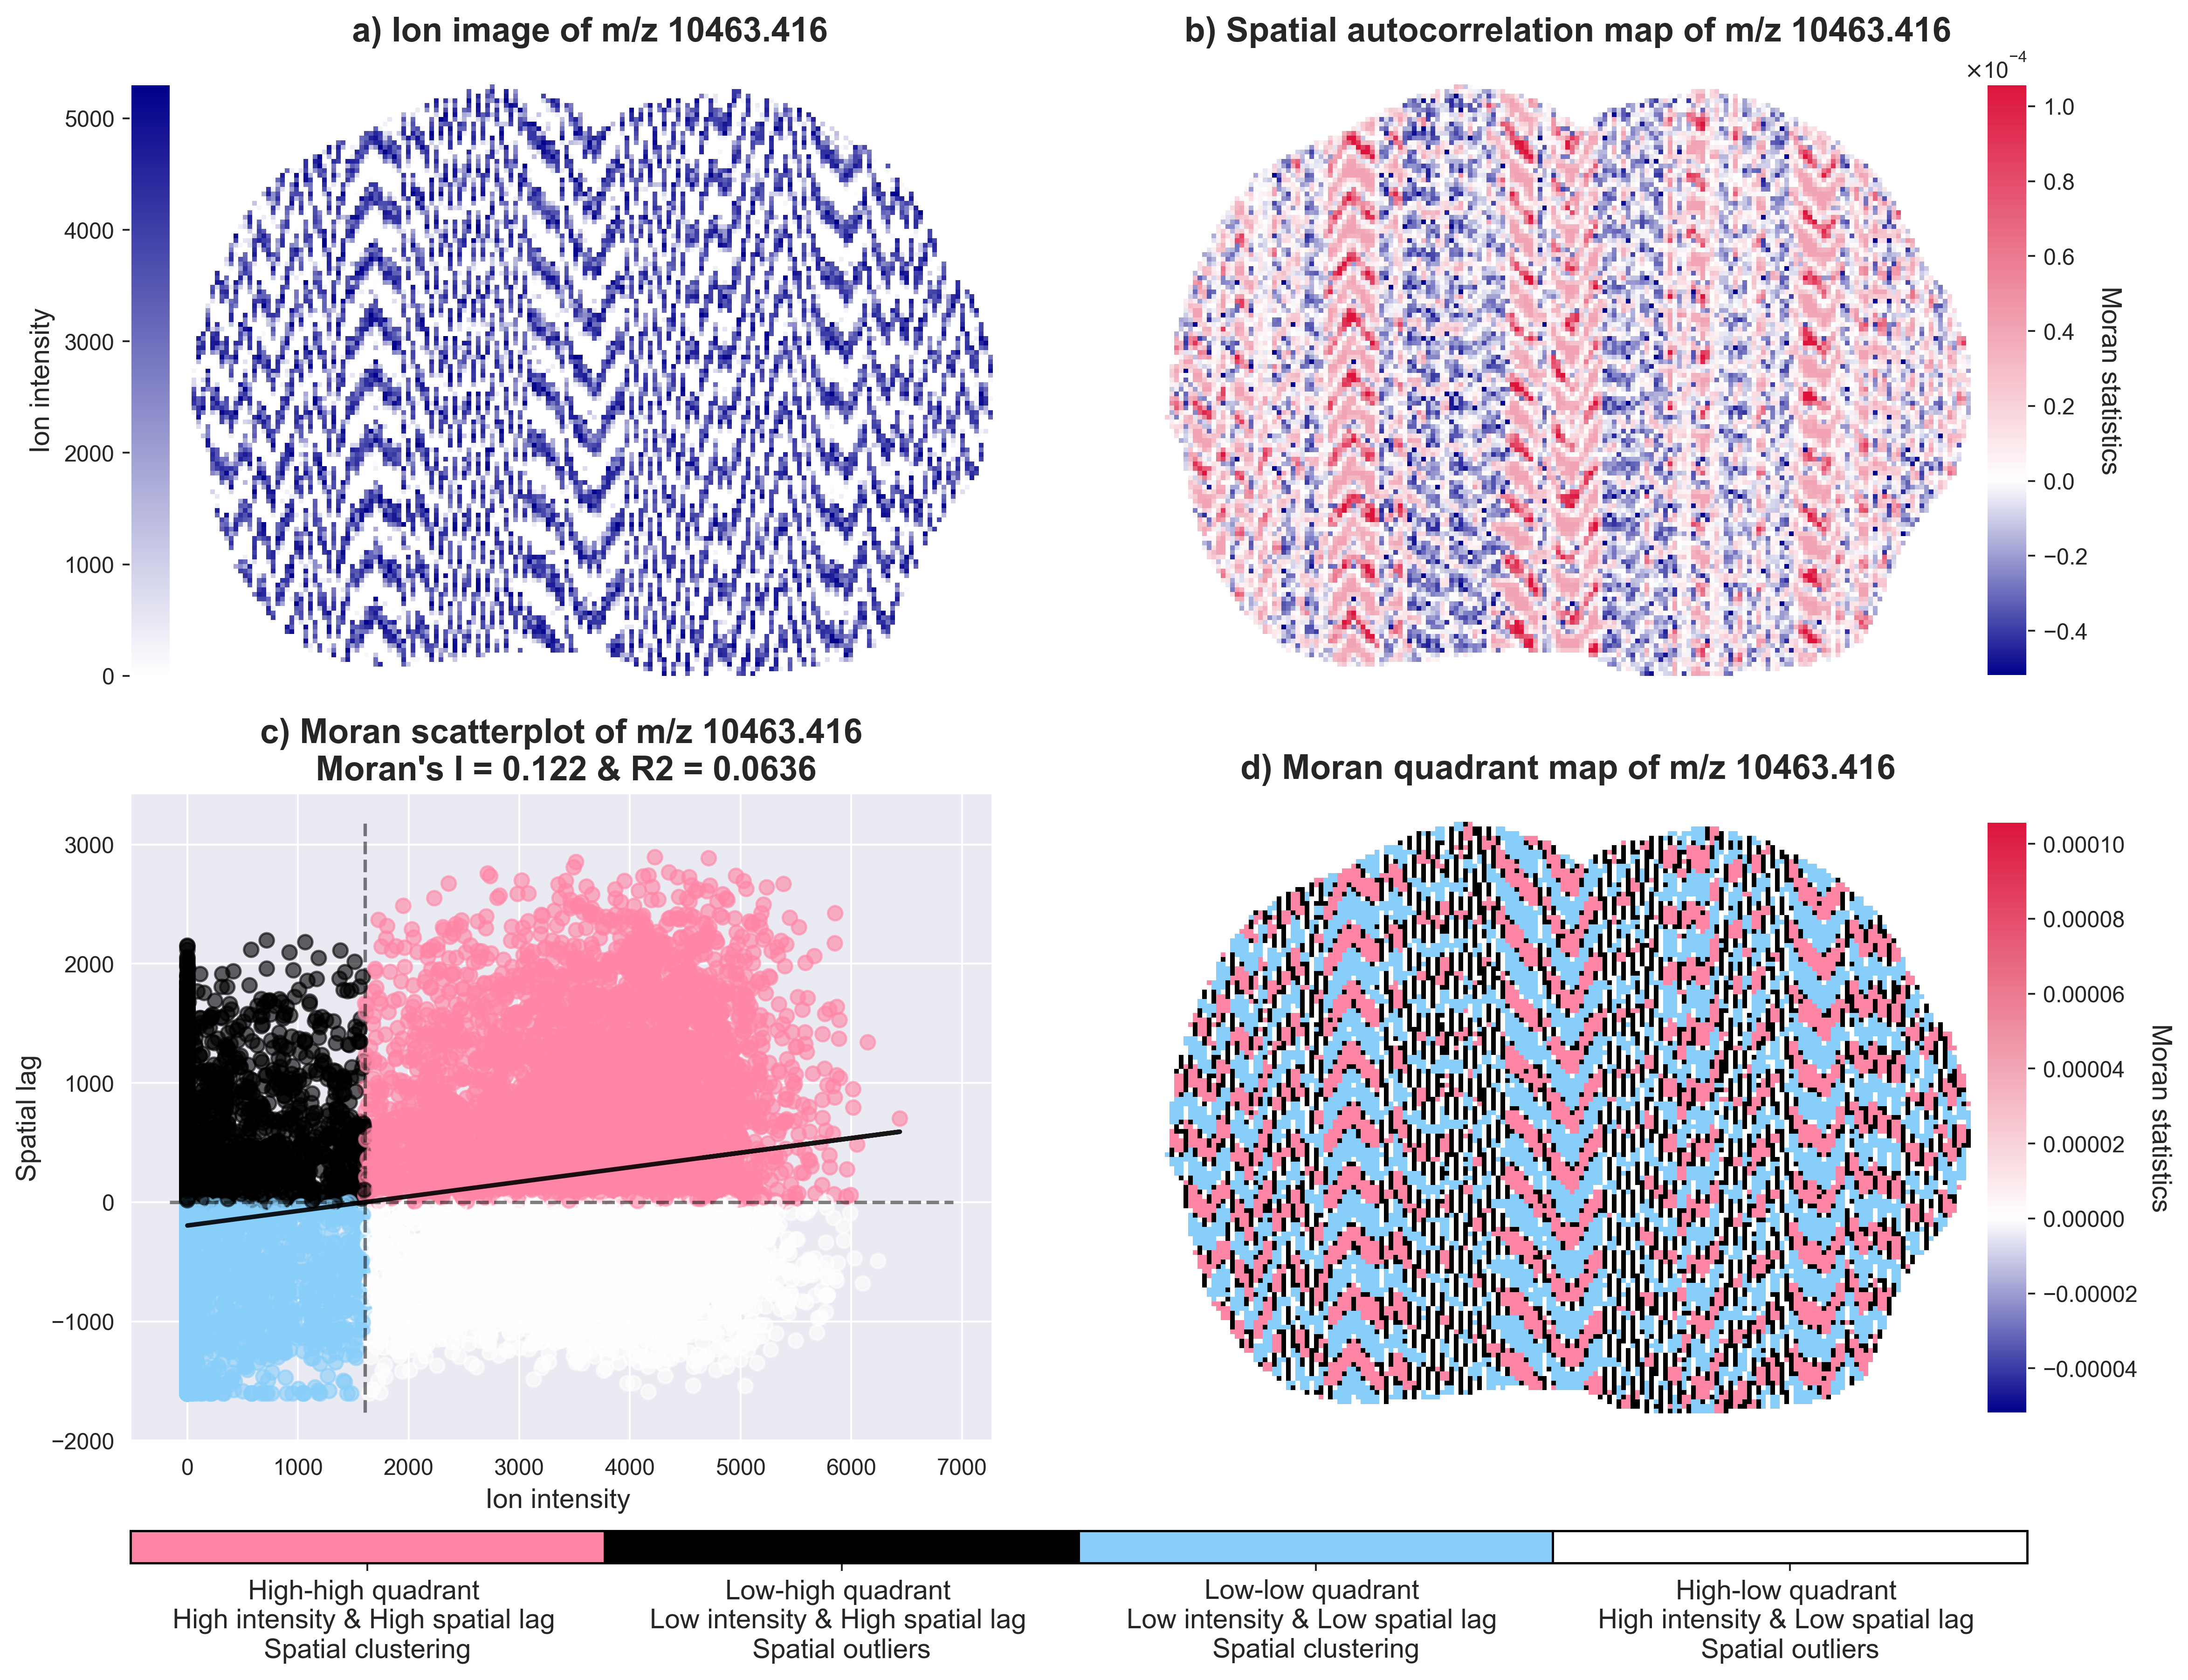

Moran's I: 0.12216
R^2: 0.0636
Mean ion intensity: 1605.1757
Mean spatial lag: 0.1657
Percentage of pixels in spatial clusters:  57.76 %


In [18]:
feature_index = 97
save_name = "./Nature_Figures/Figure_S2"
moran_quadrants, slope, intercept, R2, ion_intensity_mean, spatial_lag_mean = plot_Moran_scatterplot_quadrantplot(feature_index, dataset, weights_matrix, mz_bin_values, 
                                                                                                                  image_shape, background_mask, mean_intensity, colormap_moran, 
                                                                                                                  save_name, index_plot_start=0)

print("Moran's I:", Moran_list[feature_index])
print("R^2:", np.round(R2, 4))
print("Mean ion intensity:", np.round(ion_intensity_mean, 4))
print("Mean spatial lag:", np.round(spatial_lag_mean, 4))

# Percentage of pixels in the high-high and low-low quadrants (spatial clustering of high and low values)
card_high_high = np.sum(moran_quadrants == 1)
card_low_high = np.sum(moran_quadrants == 2)
card_low_low = np.sum(moran_quadrants == 3)
card_high_low = np.sum(moran_quadrants == 4)
Pspatial_clustering = 100 * (card_high_high + card_low_low)/(card_high_high + card_low_high + card_low_low + card_high_low)
print('Percentage of pixels in spatial clusters: ', np.round(Pspatial_clustering, 3), '%')

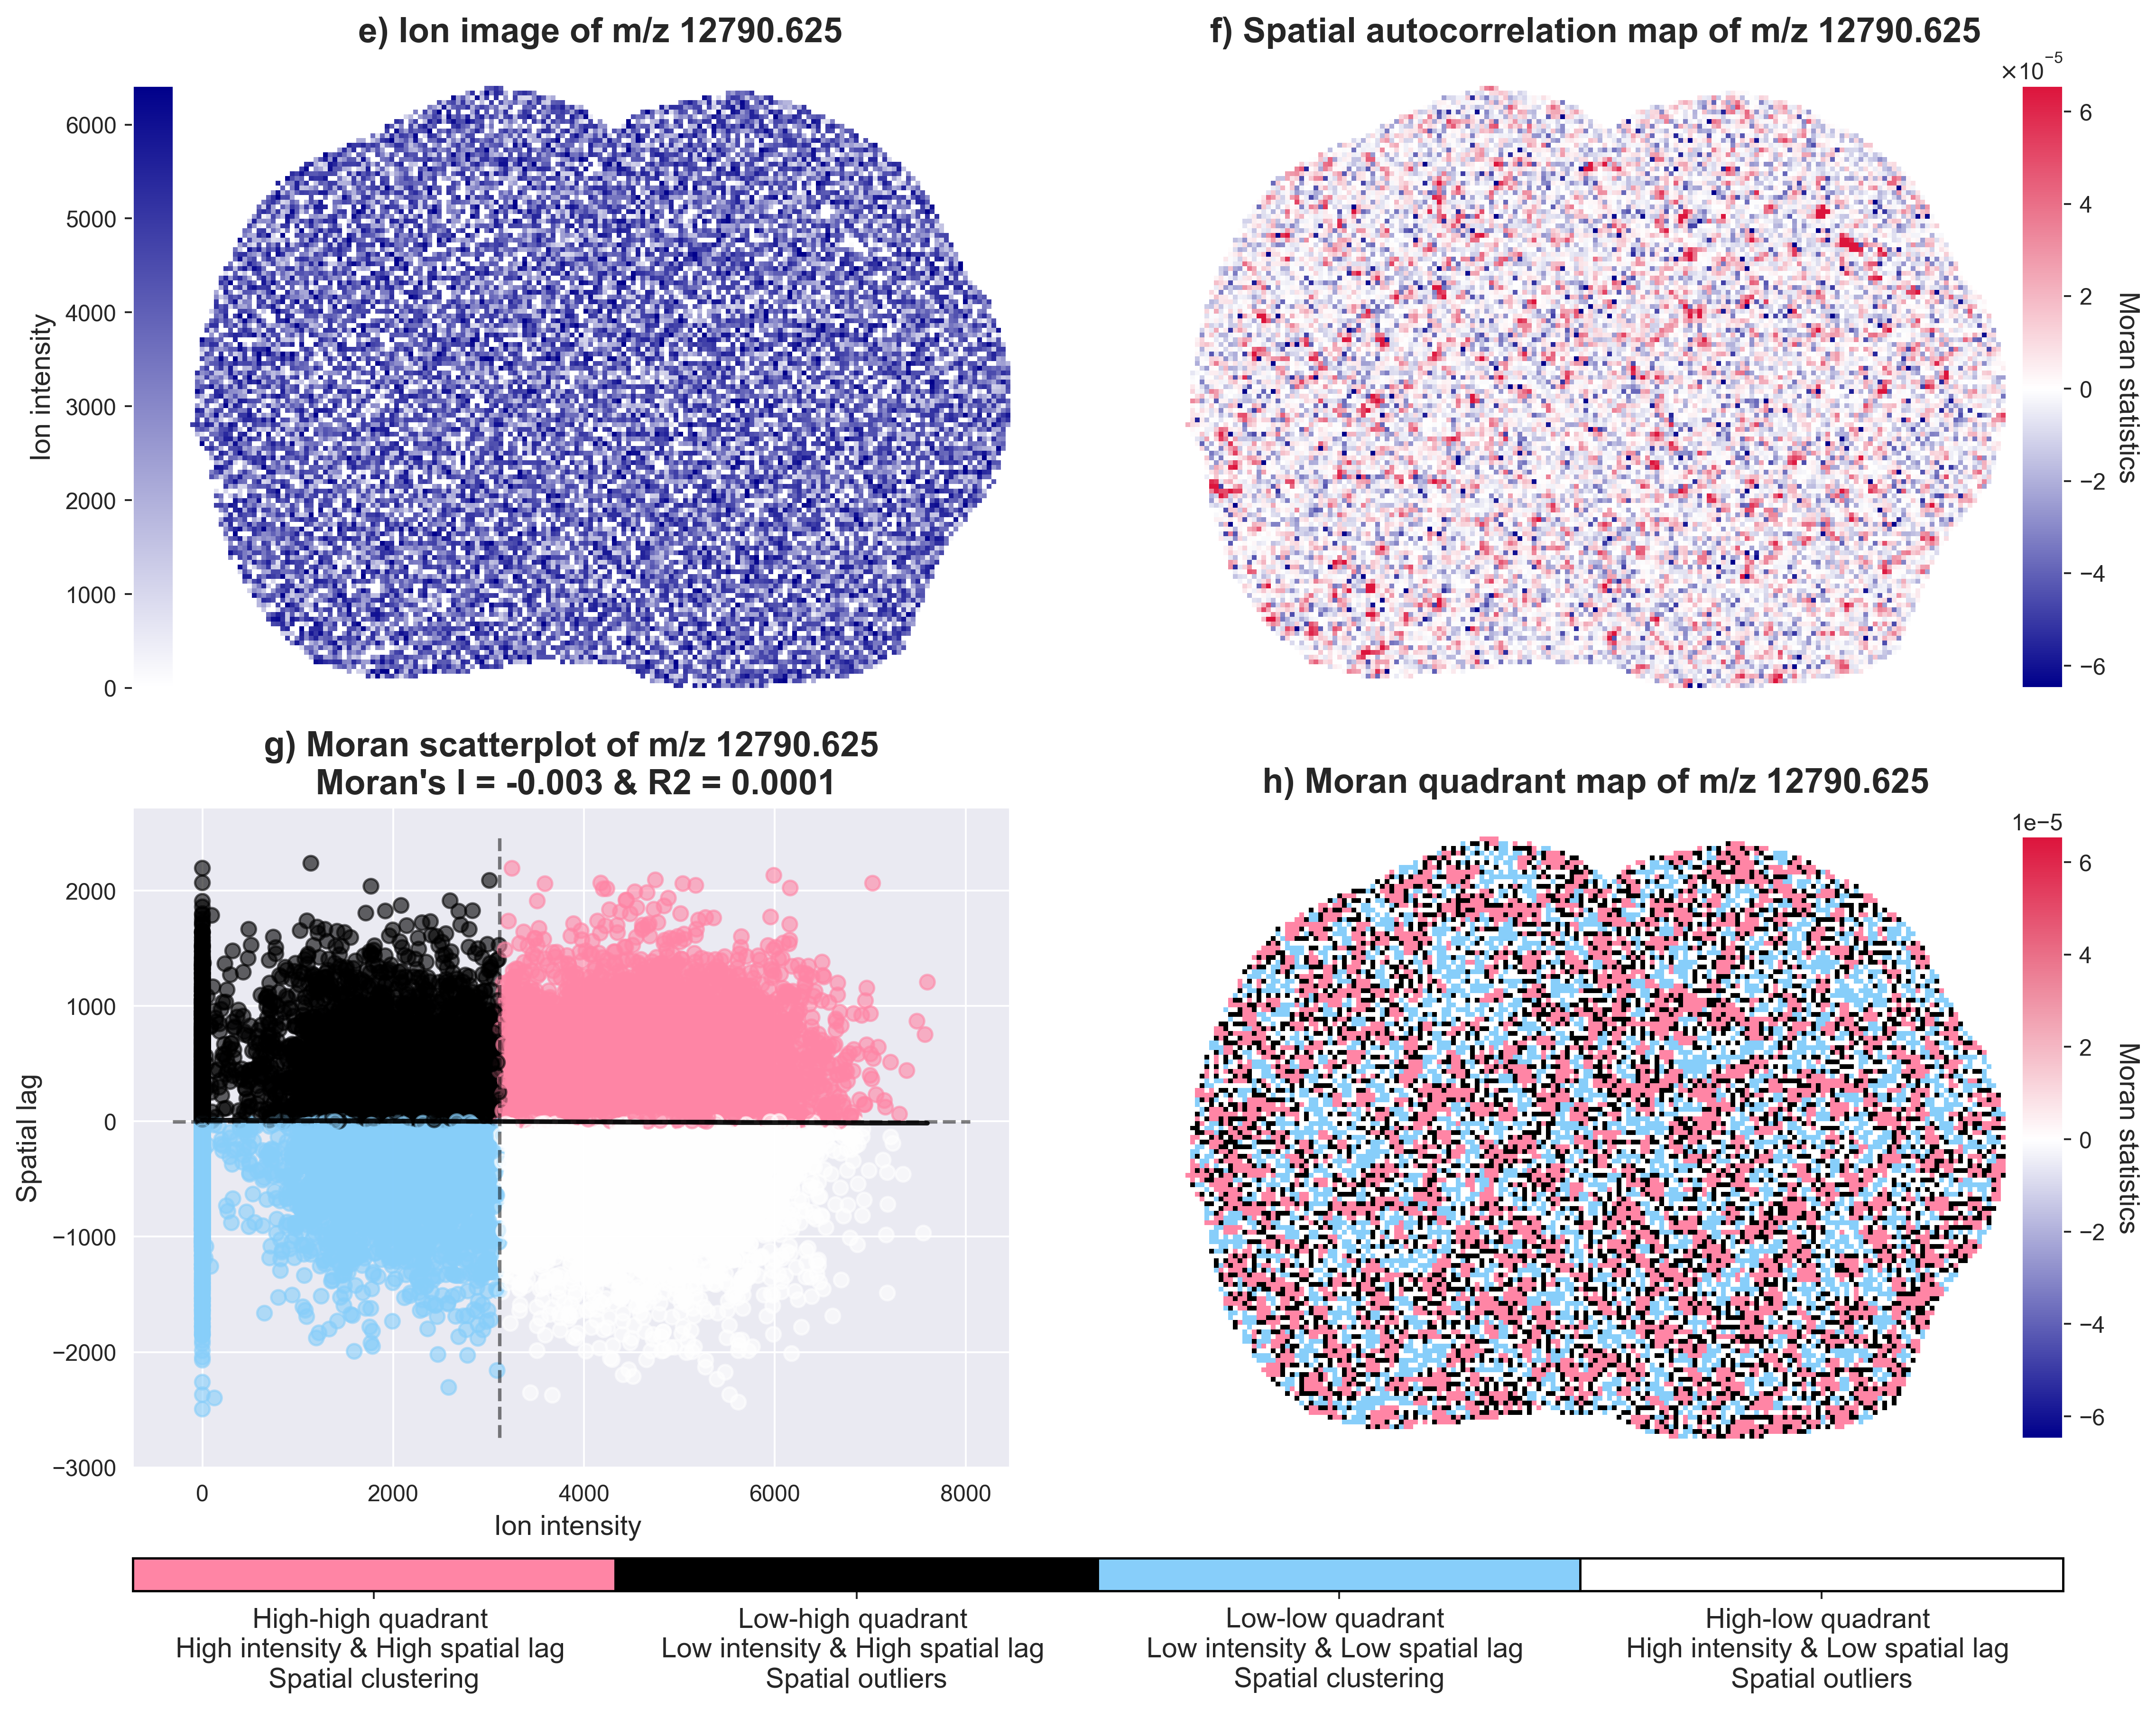

Moran's I: -0.0033
R^2: 0.0001
Mean ion intensity: 3115.1376
Mean spatial lag: -0.6947
Percentage of pixels in spatial clusters:  49.46 %


In [19]:
feature_index = 98
save_name = "./Nature_Figures/Figure_6"
moran_quadrants, slope, intercept, R2, ion_intensity_mean, spatial_lag_mean = plot_Moran_scatterplot_quadrantplot(feature_index, dataset, weights_matrix, mz_bin_values, 
                                                                                                                  image_shape, background_mask, mean_intensity, colormap_moran, 
                                                                                                                  save_name, index_plot_start=4)

print("Moran's I:", Moran_list[feature_index])
print("R^2:", np.round(R2, 4))
print("Mean ion intensity:", np.round(ion_intensity_mean, 4))
print("Mean spatial lag:", np.round(spatial_lag_mean, 4))

# Percentage of pixels in the high-high and low-low quadrants (spatial clustering of high and low values)
card_high_high = np.sum(moran_quadrants == 1)
card_low_high = np.sum(moran_quadrants == 2)
card_low_low = np.sum(moran_quadrants == 3)
card_high_low = np.sum(moran_quadrants == 4)
Pspatial_clustering = 100 * (card_high_high + card_low_low)/(card_high_high + card_low_high + card_low_low + card_high_low)
print('Percentage of pixels in spatial clusters: ', np.round(Pspatial_clustering, 3), '%')

In [20]:
%pwd

'C:\\Users\\Leo\\Documents\\Second_paper\\Final_2nd_paper\\Demo_folder_for_GitHub'